In [14]:
# Variational Bayes (VB) for univariate gaussian
# based on: https://github.com/probml/pmtk3/blob/master/demos/unigaussVbDemo.m

# Author: Gerardo Durán-Martín (@gerdm)


import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import random
from jax.scipy import stats
from dataclasses import dataclass
from jax.scipy.special import gammaln
import os
import seaborn as sns

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

In [15]:
os.environ["LATEXIFY"] = ""
os.environ["FIG_DIR"] = "figures"

In [23]:
pml.latexify(fig_height=3, fig_width=3)

In [39]:
@dataclass
class GaussGamma:
    mu: float
    beta: float
    a: float
    b: float


def generate_data(key, N):
    data = random.normal(key, (N,))
    data = (data - data.mean()) / data.std()
    return data


def gaussian_gamma_pdf(mu, lmbda, params):
    """
    Proabbility density function of a univariate gaussian-gamma distribution

    Parameters
    ----------
    mu: float
        Mean of the distribution
    lmbda: float
        Precision of the distribution
    params: GaussGamma
        Parameters of the distribution
    """
    N_part = stats.norm.pdf(mu, loc=params.mu, scale=1 / jnp.sqrt(params.beta * lmbda))
    G_part = stats.gamma.pdf(lmbda, params.a, scale=1 / params.b)
    return N_part * G_part


def vb_est_pdf(mu, lmbda, params):
    """
    Variational-bayes pdf of a univariate gaussian-gamma distribution

    Parameters
    ----------
    mu: float
        Mean of the distribution
    lmbda: float
        Precision of the distribution
    params: GaussGamma
        Parameters of the distribution
    """
    N_part = stats.norm.pdf(mu, params.mu, 1 / jnp.sqrt(params.beta))
    G_part = stats.gamma.pdf(lmbda, params.a, scale=1 / params.b)
    return N_part * G_part


# vmapped functions for contour plots
gaussian_gamma_pdf_vmap = jax.vmap(gaussian_gamma_pdf, in_axes=(0, None, None))
gaussian_gamma_pdf_vmap = jax.vmap(gaussian_gamma_pdf_vmap, in_axes=(None, 0, None))

vb_est_pdf_vmap = jax.vmap(vb_est_pdf, in_axes=(0, None, None))
vb_est_pdf_vmap = jax.vmap(vb_est_pdf_vmap, in_axes=(None, 0, None))


def plot_gauss_exact_vb(
    ax, exact_params, vb_params, mu_min=-1, mu_max=1, lambda_min=0, lambda_max=2, npoints=500, levels=5, bb=(0.1, 0.1)
):

    mu_range = jnp.linspace(mu_min, mu_max, npoints)
    lambda_range = jnp.linspace(lambda_min, lambda_max, npoints)
    proba_exact_space = gaussian_gamma_pdf_vmap(mu_range, lambda_range, exact_params)
    proba_vb_space = vb_est_pdf_vmap(mu_range, lambda_range, vb_params)

    contour_exact = ax.contour(mu_range, lambda_range, proba_exact_space, colors="tab:orange", levels=levels, lw=10)
    contour_vb = ax.contour(mu_range, lambda_range, proba_vb_space, colors="tab:blue", levels=levels)
    ax.set_xlabel(r"$\mu$", fontsize=15)
    ax.set_ylabel(r"$\tau$", fontsize=15)
    contour_exact.collections[0].set_label("exact")
    contour_vb.collections[0].set_label("VB")

    h1, _ = contour_exact.legend_elements()
    h2, _ = contour_vb.legend_elements()
    ax.legend([h1[0], h2[0]], ["Exact", "VB"], bbox_to_anchor=bb, frameon=False, fontsize=11)
    sns.despine()
    ax.tick_params(axis="both", which="major", labelsize=14)

    #     ax.axis("equal")
    ax.set_aspect("equal")


def vb_unigauss_learn(data, params_prior, params_init, eps=1e-6):
    """
    Variational Bayes (VB) procedure for estimating the parameters
    of a univariate gaussian distribution

    Parameters
    ----------
    data: jnp.ndarray
        Data to estimate the parameters of the distribution
    params_prior: GaussGamma
        Prior parameters of the distribution
    params_init: GaussGamma
        Initial parameters of the VB estimation
    eps: float
        Tolerance for the convergence of the VB procedure

    Returns
    -------
    * The VB-estimated parameters
    * History of the estimation of parameters after updating
        the mean and after updating the precision
    """
    lower_bound = -jnp.inf
    xbar = jnp.mean(data)

    mu0, beta0 = params_prior.mu, params_prior.beta
    a0, b0 = params_prior.a, params_prior.b

    muN, betaN = params_init.mu, params_init.beta
    aN, bN = params_init.a, params_init.b

    converge = False
    params_hist = []
    while not converge:
        est_params = GaussGamma(muN, betaN, aN, bN)
        params_hist.append(est_params)

        # update q_mu
        e_tau = aN / bN
        muN = (beta0 * mu0 + N * xbar) / (beta0 + N)
        betaN = (beta0 + N) * e_tau

        est_params = GaussGamma(muN, betaN, aN, bN)
        params_hist.append(est_params)

        # update q_tau
        e_mu = xbar
        e_mu2 = 1 / betaN + muN**2
        aN = a0 + (N + 1) / 2
        bN = b0 + beta0 * (e_mu2 + mu0**2 - 2 * mu0 * e_mu) / 2 + (data**2 + e_mu2 - 2 * e_mu * data).sum() / 2

        est_params = GaussGamma(muN, betaN, aN, bN)
        params_hist.append(est_params)

        lower_bound_new = -jnp.log(betaN) - gammaln(aN) * jnp.log(bN)
        if abs(lower_bound_new / lower_bound - 1) < eps:
            converge = True
            est_params = GaussGamma(muN, betaN, aN, bN)
            params_hist.append(est_params)
        else:
            lower_bound = lower_bound_new

    return est_params, params_hist

/home/patel_karm/anaconda3/envs/py3713/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: The following kwargs were not used by contour: 'lw'


saving image to figures/unigauss_vb_0_latexified.pdf
Figure size: [3. 3.]


/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:71: UserWarning: renaming figures/unigauss_vb_1.pdf to figures/unigauss_vb_1_latexified.pdf because LATEXIFY is True
  f"renaming {fname_full} to {fname}{extention} because LATEXIFY is {LATEXIFY}",


saving image to figures/unigauss_vb_1_latexified.pdf
Figure size: [3. 3.]


/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:71: UserWarning: renaming figures/unigauss_vb_2.pdf to figures/unigauss_vb_2_latexified.pdf because LATEXIFY is True
  f"renaming {fname_full} to {fname}{extention} because LATEXIFY is {LATEXIFY}",


saving image to figures/unigauss_vb_2_latexified.pdf
Figure size: [3. 3.]


/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:71: UserWarning: renaming figures/unigauss_vb_3.pdf to figures/unigauss_vb_3_latexified.pdf because LATEXIFY is True
  f"renaming {fname_full} to {fname}{extention} because LATEXIFY is {LATEXIFY}",


saving image to figures/unigauss_vb_3_latexified.pdf
Figure size: [3. 3.]


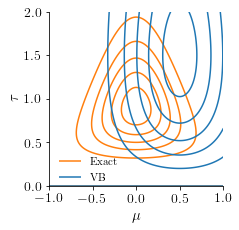

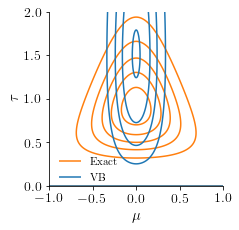

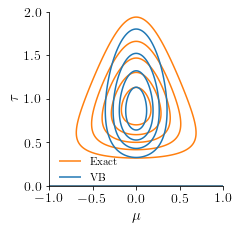

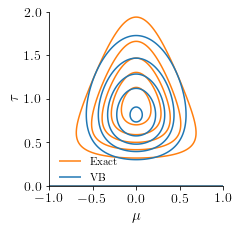

In [43]:
# plt.rcParams["axes.spines.right"] = False
# plt.rcParams["axes.spines.top"] = False
key = random.PRNGKey(3141)
N = 10
data = generate_data(key, N)

# prior parameters of the distribution
mu0, beta0, a0, b0 = jnp.zeros(4)
params_prior = GaussGamma(mu0, beta0, a0, b0)

# exact parameters of the posterior distribution
# (according to the specified priors with values zero)
x_bar = jnp.mean(data)
mu_post = jnp.mean(data)
beta_post = N
a_post = N / 2
b_post = jnp.sum((data - mu_post) ** 2) / 2
posterior_params = GaussGamma(mu_post, beta_post, a_post, b_post)

# variational-bayes (VB) estimation of the posterior parameters
params_vb_init = GaussGamma(mu=0.5, beta=5, a=2.5, b=1)
_, params_hist = vb_unigauss_learn(data, params_prior, params_vb_init)

# We take the indices of
# 1. our initial estimate,
# 2. after q_mu update in the first iteration
# 3. after q_tau update in the second iteration
# 4. after convergence
params_ix = [0, 1, 2, -1]
for i, ix_param in enumerate(params_ix):
    fig, ax = plt.subplots()
    vb_params = params_hist[ix_param]
    plot_gauss_exact_vb(ax, posterior_params, vb_params, bb=(0.45, 0.22))
    pml.savefig(f"unigauss_vb_{i}.pdf")

plt.show()